# Install and import packages

In [ ]:
!pip install beir mteb pandas

In [ ]:
from beir import util, LoggingHandler
from beir.retrieval import models
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES

import pandas as pd

from collections import defaultdict

import logging
import pathlib, os

# Download and unzip dataset if necessary

In [ ]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
#### /print debug information to stdout

#### Download scifact.zip dataset and unzip the dataset
dataset = "cqadupstack"
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
out_dir = os.path.join(pathlib.Path('.').parent.absolute(), "datasets")
data_path = util.download_and_unzip(url, out_dir)

# Benchmark
## Preparation

In [ ]:
benchmark_results = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

Configure subsets and models to evaluate

In [ ]:
subsets = [
    "android",
    "english",
    "gaming",
    "gis",
    "mathematica",
    "physics",
    "programmers",
    "stats",
    "tex",
    "unix",
    "webmasters",
    "wordpress"
]

model_names = [
    "WhereIsAI/UAE-Large-V1",
    "BAAI/bge-large-en-v1.5",
    "BAAI/bge-base-en-v1.5",
    "thenlper/gte-large",
    "thenlper/gte-base"
]

model_name = model_names[4]

## Run benchmark

In [ ]:
# Configure bins and labels
bins = [1, 50, 100, 2000]
bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]

# Set model and retriever
print(f"Benchmarking {model_name}")
model = DRES(models.SentenceBERT(model_name), batch_size=16)
retriever = EvaluateRetrieval(model, score_function="dot")

for subset in subsets:
  print(f"Benchmarking {subset}")

  # Load dataset
  corpus, queries, qrels = GenericDataLoader(data_folder=f"datasets/cqadupstack/{subset}").load(split="test")

  # Create dataframe to calculate word count and assign bins
  corpus_df = pd.DataFrame.from_dict(corpus, orient='index')
  corpus_df['word_count'] = corpus_df['text'].apply(lambda x: len(x.split()))
  corpus_df['bin'] = pd.cut(corpus_df['word_count'], bins=bins, labels=bin_labels)

  # Retrieve results
  results = retriever.retrieve(corpus, queries)

  for i in range (0, len(bins)-1):
    bin_start = bins[i]
    bin_end = bins[i+1]
    bin_label = bin_labels[i]

    qrel_keys = []

    # Filter query-corpus relations for current bin
    for qrel_key, qrel_value in qrels.items():
      for corpus_key in qrel_value:
        if corpus_df.loc[corpus_key]['bin'] == bin_label:
          qrel_keys.append(qrel_key)

    bin_qrels = {k: qrels[k] for k in qrel_keys}

    # Save result count for current bin
    benchmark_results[model_name][subset][bin_label]['count'] = len(bin_qrels)

    # Evaluate results for current bin
    ndcg, _map, recall, precision = retriever.evaluate(bin_qrels, results, retriever.k_values)

    # Save NDCG@10
    benchmark_results[model_name][subset][bin_label]['NDCG@10'] = ndcg['NDCG@10']

Benchmarking thenlper/gte-base
Benchmarking english


  0%|          | 0/40221 [00:00<?, ?it/s]

Batches:   0%|          | 0/99 [00:00<?, ?it/s]

Batches:   0%|          | 0/2514 [00:00<?, ?it/s]

Benchmarking physics


  0%|          | 0/38316 [00:00<?, ?it/s]

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

Batches:   0%|          | 0/2395 [00:00<?, ?it/s]

## Visualization

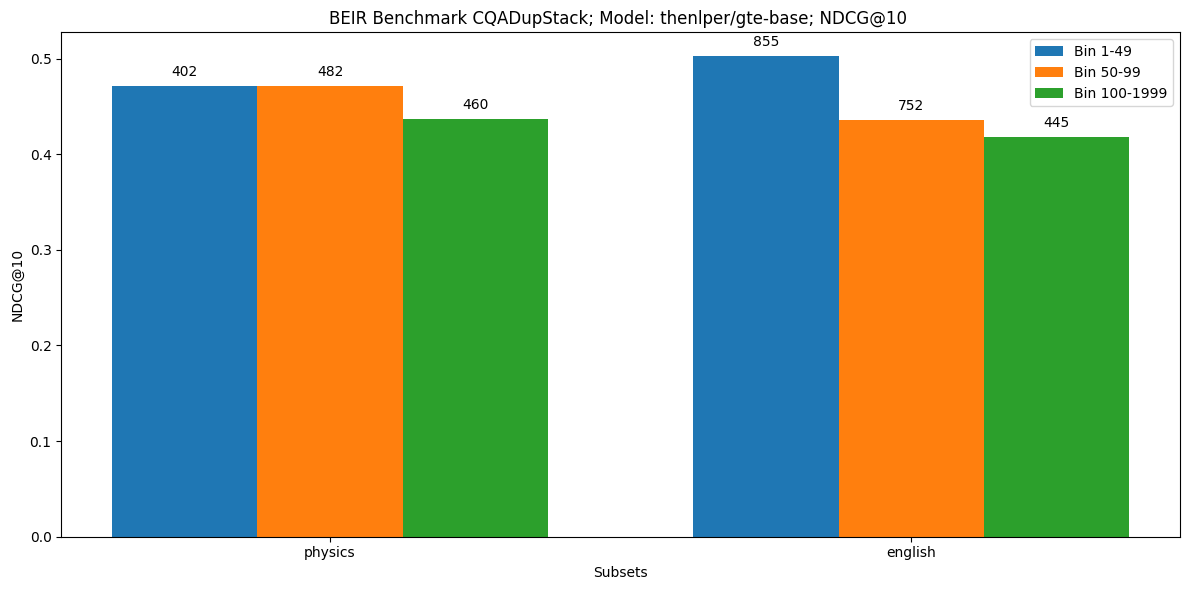

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

subset_names = []
bin_names = []
ndcg_values = []
count_values = []

# Extract data for plotting
for model in benchmark_results:
    for subset in benchmark_results[model]:
        subset_name = subset
        subset_bins = []
        subset_ndcg_values = []
        subset_count_values = []
        for bin_name, bin_data in benchmark_results[model][subset].items():
            subset_bins.append(bin_name)
            subset_ndcg_values.append(bin_data['NDCG@10'])
            subset_count_values.append(bin_data['count'])
        subset_names.append(subset_name)
        bin_names.append(subset_bins)
        ndcg_values.append(subset_ndcg_values)
        count_values.append(subset_count_values)

# Plotting
num_subsets = len(subset_names)
num_bins = max(len(bins) for bins in bin_names)
width = 1  # Adjust the width here
spacing = 1  # Adjust the spacing between subsets here

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(num_bins):
    x = np.arange(num_subsets) * (width + spacing * num_bins) + i * width
    ax.bar(x, [ndcg_values[j][i] for j in range(num_subsets)], width=width, label=f'{bin_labels[i]} Words/Document')

    for j in range(num_subsets):
        x_pos = x[j]
        y_pos = ndcg_values[j][i]
        count_val = count_values[j][i]
        ax.annotate(f'{count_val}', xy=(x_pos, y_pos), xytext=(0, 5),
                    textcoords='offset points', ha='center', va='bottom')

ax.set_ylabel('NDCG@10')
ax.set_xlabel('Subsets')
ax.set_title('BEIR Benchmark CQADupStack; Model: thenlper/gte-base; NDCG@10 ')
ax.set_xticks(np.arange(num_subsets) * (width + spacing * num_bins) + (num_bins - 1) * width / 2)
ax.set_xticklabels(subset_names)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Prepare a sorted list of all the bins
all_bins = sorted(set(bin for model in benchmark_results for subset in benchmark_results[model] for bin in benchmark_results[model][subset]))

# Print a table for each model
for model in benchmark_results:
    # Determine the maximum length of each subset
    max_subset_length = max(len(str(subset)) for subset in benchmark_results[model])

    # Print the table header
    print(f"Model: {model}")
    print(f"{'Subset':<{max_subset_length}}", end="")  # Print the subset column header
    for bin in all_bins:
        print(f"{bin}\t", end="")  # Print the bins as column headers
    print()  # Move to the next line

    # Print the table body
    for subset in benchmark_results[model]:
        print(f"{subset:<{max_subset_length}}", end="")  # Print the subset name

        for bin in all_bins:
            if bin in benchmark_results[model][subset]:
                ndcg_value = benchmark_results[model][subset][bin]['NDCG@10']
                print(f"{ndcg_value:.4f}\t", end="")  # Print the NDCG@10 value in the corresponding cell
            else:
                print("\t", end="")  # Print an empty cell if the bin is not available for the subset

        print()  # Move to the next line

    print()  # Create a separation line between tables


Model: thenlper/gte-base
Subset     1-99	100-499	500-1999	
android    0.5485	0.4206	0.4677	
english    0.4884	0.4151	0.4212	
gaming     0.6119	0.5517	0.0000	
gis        0.4609	0.3434	0.3213	
mathematica0.3430	0.2879	0.2403	
physics    0.4858	0.4376	0.4107	
programmers0.4693	0.3972	0.3378	
stats      0.3729	0.3341	0.4264	
tex        0.3262	0.2617	0.2470	
unix       0.4365	0.3692	0.1456	
webmasters 0.4102	0.3770	0.5867	
wordpress  0.3807	0.3149	0.2616	



# Clear cache if necessary

In [ ]:
model = None
tokenizer = None
retriever = None
corpus = None
queries = None
qrels = None

#clear cache

import os
import gc
import torch

def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

clear_cache()